In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Load data

In [2]:
from pathlib import Path
import os

data_dir = Path('./data/')
data_path = Path('./data/fashion_mnist.npz')

if data_path.is_file():
    print('Data found. Loading...')
    data = np.load(data_path)
    X_train, Y_train, X_test, Y_test = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
else:
    print('Data not found. Downloading...')
    if not data_dir.is_dir():
        os.mkdir(data_dir)
    from keras.datasets import fashion_mnist
    (X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
    X_train, X_test = X_train/255., X_test/255.
    np.savez_compressed(data_path, X_train, Y_train, X_test, Y_test)

Data found. Loading...


In [3]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
CLASS_LABELS = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

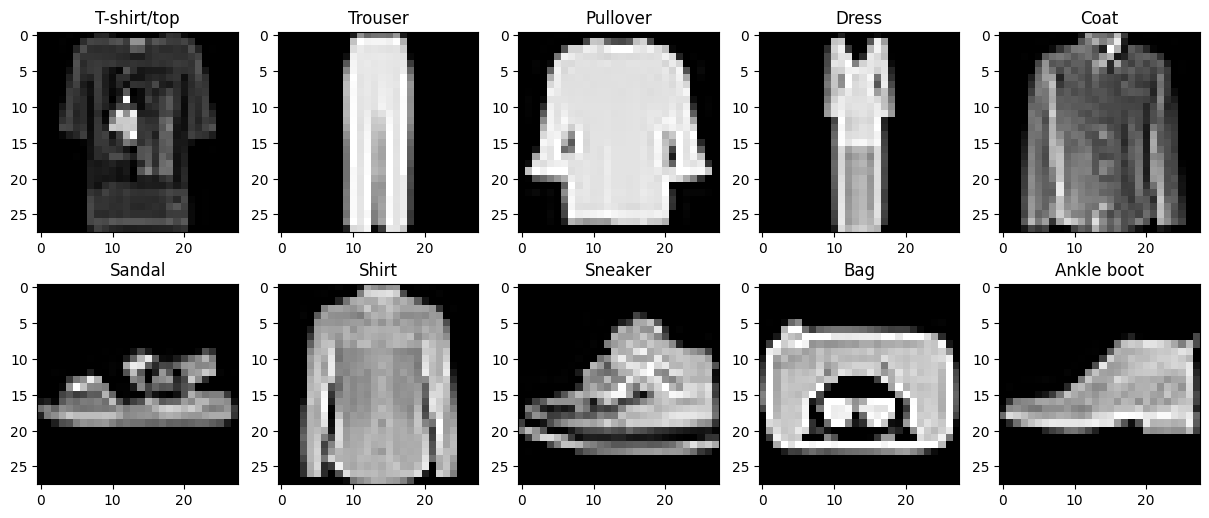

In [5]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    row_no = i//5
    col_no = i%5
    X_sub = X_train[Y_train==i]
    index = np.random.choice(a=range(len(X_sub)), size=1)
    ax[row_no][col_no].imshow(X_sub[index].reshape((28, 28)), cmap='gray')
    ax[row_no][col_no].set_title(CLASS_LABELS[i])

## Activations

In [6]:
class Identity():
    """
    Implements the identity function, f(x) = x
    """
    def __init__(self) -> None:
        pass

    def forward(self, x):
        """
        Returns identity(x) for input x
        """
        return x
    
    def backward(self, output, y_true=None):
        """
        Returns gradient of identity output wrt inputs, given the output
        """
        return np.ones_like(output)

In [7]:
class Sigmoid():
    """
    Implements the sigmoid logistic function, f(x) = 1/(1 + exp(-x))
    """
    def __init__(self) -> None:
        pass

    def forward(self, x):
        """
        Returns sigmoid(x) for input x
        """
        return 1 / (1 + np.exp(-x))
    
    def backward(self, output, y_true=None):
        """
        Returns gradient of sigmoid outputs wrt inputs, given the output
        """
        return output * (1 - output)

In [8]:
class ReLU():
    """
    Implements the rectified linear unit (ReLU) function, f(x) = max(0, x) 
    """
    def __init__(self) -> None:
        pass
        
    def forward(self, x):
        """
        Returns relu(x) for input x
        """
        return np.maximum(0., x)
    
    def backward(self, output, y_true=None):
        """
        Returns gradient of relu outputs wrt inputs, given the output
        """
        return np.sign(output, dtype=np.float64)

In [9]:
class Tanh():
    """
    Implements the hyperbolic tan (tanh) function, f(x) = (exp(x) - exp(-x))/(exp(x) + exp(-x))
    """
    def __init__(self) -> None:
        pass

    def forward(self, x):
        """
        Returns tanh(x) for input x
        """
        # tanh(x) = (exp(2x) - 1)/(exp(2x) + 1) = 2 / (1 + exp(-2x)) - 1
        return 2 / (1 + np.exp(-2*x)) - 1
    
    def backward(self, output, y_true=None):
        """
        Returns gradient of tanh outputs wrt inputs, given the output
        """
        # d(tanh(x))/dx = 4exp(2x)/(1 + exp(2x))**2
        # exp(2x)/(1 + exp(2x)) = (tanh(x) + 1)/2, 1/(1 + exp(2x)) = (1 - tanh(x))/2
        # d(tanh(x))/dx = 1 - tanh(x)**2
        return 1 - output**2

In [10]:
class Softmax():
    """
    Implements the softmax function, f(x) = exp(x) / sum(exp(x))
    """
    def __init__(self) -> None:
        pass

    def forward(self, x):
        """
        Returns softmax(x) for input x
        """
        exp_x = np.exp(x) # experiencing overflows here, find better method
        total = np.sum(exp_x)
        return exp_x / total
    
    def backward(self, output, y_true): # try to do it without y_true (check if possible)
        """
        Returns gradient of softmax outputs wrt inputs, given the output and true class
        """
        e_l = np.zeros(len(output))
        e_l[y_true] = 1.
        return output[y_true] * (e_l - output)

## Loss functions

In [11]:
class CrossEntropyLoss():
    """
    Implements the cross entropy loss, L(y_hat, y) = -log(y_hat[y]) [where y is the true class label, from 0 to num_classes-1]
    """
    def __init__(self) -> None:
        pass

    def forward(self, y_pred, y_true):
        """
        Returns the loss for predicted probabilities y_pred, with true class label y_true
        """
        return -np.log(y_pred[y_true])
    
    def backward(self, y_pred, y_true):
        """
        Returns the derivative of the loss wrt the predicted probability of the true class y_true
        """
        grad = np.zeros_like(y_pred)
        grad[y_true] = -1 / y_pred[y_true]
        return grad
    
# Remember, these activations and loss have been implemented for a single data point, and may need to be implemented more rigorously for multiple inputs at once

## Feedforward neural network

In [12]:
class Layer():
    """
    Models a single layer of a feedforward neural network. 

    Args:
        input_size (int): number of inputs to the layer
        output_size (int): number of outputs produced by the layer
        activation (str, optional): activation function used by the layer. 
            Allowed activations: 'identity', 'sigmoid', 'tanh', 'relu', 'softmax'
            Defaults to 'sigmoid'.
        weight_init (str, optional): type of initialization to be performed for the weights and biases
            Allowed initializations: 'random', 'xavier'
            Defaults to 'random'.
    """
    def __init__(
        self,
        input_size: int,
        output_size: int,
        activation: str = 'sigmoid',
        weight_init: str = 'random'
    ) -> None:
        # Handle to allow weight init
        self.w = np.random.normal(size=(output_size, input_size))   # shape: (output_size, input_size)
        self.b = np.random.normal(size=(output_size,))  # shape: (output_size,)
        self.grad_w = np.zeros_like(self.w)
        self.grad_b = np.zeros_like(self.b)
        if activation == 'identity':
            self.activation = Identity()
        elif activation == 'sigmoid':
            self.activation = Sigmoid()
        elif activation == 'tanh':
            self.activation = Tanh()
        elif activation == 'relu':
            self.activation = ReLU()
        elif activation == 'softmax':
            self.activation = Softmax()
    
    def forward(self, x: np.array) -> np.array:
        """
        Computes the output of the layer for given input.

        Arg: x (numpy.array): the input vector for the layer, of size (input_size,)
        Returns: h (numpy.array): the output produced by the layer, of size (output_size,)
        """
        self.input = x
        self.pre_activation = np.matmul(self.w, x) + self.b
        self.output = self.activation.forward(self.pre_activation)
        return self.output
    
    def backward(self, accumulated_grads, y_true=None, w_next=None):
        """
        Computes the relevant necessary gradients of the layer, given the gradient accumulated until the succeeding layer.

        Args:
            accumulated_grads: gradient accumulated from the loss until the following layer, i.e. grad(L) wrt a_(i+1)
            y_true (optional): compatiblity feature, required only for the output layer for softmax activation.
                Defaults to None.
            w_next (optional): weight associated with the succeeding layer. Not applicable for the output layer.
                Defaults to None.
        
        Returns: grad_to_return, gradient accumulated until the current layer, i.e., grad(L) wrt a_i
        """
        # accumulated_grads ~ grad(L) wrt a_i+1
        # print(f'Accumulated grads: {accumulated_grads.shape}, W: {self.w.shape}, b: {self.b.shape}')
        activation_grad = self.activation.backward(self.output, y_true)
        if w_next is not None:
            grad_to_return = np.matmul(w_next.T, accumulated_grads.reshape(-1, 1)).reshape(-1,) * activation_grad
        else:
            grad_to_return = accumulated_grads * activation_grad
        # grad_to_return ~ grad(L) wrt a_i
        # print(f'Grad of activation:{activation_grad.shape}, Grad to return: {grad_to_return.shape}, input: {self.input.shape}')
        self.grad_w += np.matmul(grad_to_return.reshape(-1, 1), self.input.reshape(1, -1))
        self.grad_b += grad_to_return
        return grad_to_return

In [13]:
class FeedForwardNeuralNetwork():
    """
    Models a vanilla feedforward neural network, with softmax activation for the outputs.

    Args:
        num_layers (int): number of hidden layers in the network
        hidden_size (int): number of neurons per hidden layer
        input_size (int): size/dimension of inputs given to the network. 
            Defaults to 784, flattened size of mnist/fashion-mnist data.
        output_size (int): number of outputs produced by the network.
            Defaults to 10, number of classes of mnist/fashion-mnist data.
        activation (str, optional): activation function for the hidden layers.
            Allowed activations: 'identity', 'sigmoid', 'tanh', 'relu'
            Defaults to 'sigmoid'.
        weight_init (str, optional): type of initialization to be performed for the weights and biases
            Allowed initializations: 'random', 'xavier'
            Defaults to 'random'.
    """
    def __init__(
        self,
        num_layers: int,
        hidden_size: int,
        input_size: int = 784,
        output_size: int = 10,
        activation: str = 'sigmoid',
        weight_init: str = 'random'
    ) -> None:
        self.input_layer = Layer(input_size, hidden_size, activation, weight_init)
        self.hidden_layers = []
        for i in range(num_layers-1):
            self.hidden_layers.append(Layer(hidden_size, hidden_size, activation, weight_init))
        self.output_layer = Layer(hidden_size, output_size, 'softmax', weight_init)
    
    def forward(self, x: np.array) -> np.array:
        """
        Computes the output of the network for given input.

        Arg: x (numpy.array): the input to the network, of size (input_size,)
        Returns: y_hat (numpy.array): the output produced by the network, of size (output_size,)
        """
        result = self.input_layer.forward(x)
        for hidden_layer in self.hidden_layers:
            result = hidden_layer.forward(result)
        return self.output_layer.forward(result)
    
    def backward(self, accumulated_grads, y_true) -> None:
        """
        Computes the gradient of the loss wrt all the parameters (weights, biases) of the network, given the gradient of the loss
        wrt the output of the network.

        Args:
            accumulated_grads: gradient of the loss wrt the outputs of the network
            y_true: the true class label for the data input to the network
        """
        accumulated_grads = self.output_layer.backward(accumulated_grads, y_true)
        w_next = self.output_layer.w
        for hidden_layer in self.hidden_layers:
            accumulated_grads = hidden_layer.backward(accumulated_grads, w_next=w_next)
            w_next = hidden_layer.w
        self.input_layer.backward(accumulated_grads, w_next=w_next)
    
    def zero_grad(self) -> None:
        """
        Sets the gradients of all the parameters of the network to zero.
        """
        self.output_layer.grad_w, self.output_layer.grad_b = 0., 0.
        for hidden_layer in self.hidden_layers:
            hidden_layer.grad_w, hidden_layer.grad_b = 0., 0.
        self.input_layer.grad_w, self.input_layer.grad_b = 0., 0.
    
    def update_weights(self, lr: float = 1e-3) -> None:
        """
        Updates the parameters of the network along the direction of the negative gradient.

        Arg: lr (float, optional): learning rate for the update. Defaults to 1e-3.
        """
        self.output_layer.w -= lr * self.output_layer.grad_w
        self.output_layer.b -= lr * self.output_layer.grad_b
        for hidden_layer in self.hidden_layers:
            hidden_layer.w -= lr * hidden_layer.grad_w
            hidden_layer.b -= lr * hidden_layer.grad_b
        self.input_layer.w -= lr * self.input_layer.grad_w
        self.input_layer.b -= lr * self.input_layer.grad_b
        

## Checking out

In [14]:
random_index = np.random.choice(range(len(X_train)), 1)
random_index

array([51467])

In [15]:
X_train_point = X_train[random_index].reshape(-1,)
Y_train_point = Y_train[random_index]

In [16]:
model = FeedForwardNeuralNetwork(num_layers=3, hidden_size=16, activation='tanh')

In [17]:
loss_fn = CrossEntropyLoss()

In [18]:
train_history = {
    'epoch': [],
    'loss': []
}

for i in range(50):
    model.zero_grad()
    y_pred = model.forward(X_train_point)
    loss = loss_fn.forward(y_pred, Y_train_point)
    print(i, loss, sep='\t\t')
    train_history['epoch'].append(i)
    train_history['loss'].append(loss)
    grad_loss = loss_fn.backward(y_pred, Y_train_point)
    model.backward(grad_loss, Y_train_point)
    model.update_weights(lr=0.1)

0		[7.31006144]
1		[4.76291158]
2		[6.53481935]
3		[9.03798271]
4		[7.35680899]
5		[5.61590897]
6		[3.41424514]
7		[2.58627817]
8		[1.45516612]
9		[0.37727314]
10		[0.16726767]
11		[0.11515451]
12		[0.0899771]
13		[0.07472155]
14		[0.06432993]
15		[0.05672259]
16		[0.05087425]
17		[0.04621608]
18		[0.04240492]
19		[0.03922046]
20		[0.03651416]
21		[0.03418192]
22		[0.03214845]
23		[0.03035778]
24		[0.0287674]
25		[0.02734438]
26		[0.02606278]
27		[0.02490185]
28		[0.02384481]
29		[0.0228779]
30		[0.02198973]
31		[0.02117081]
32		[0.02041312]
33		[0.01970987]
34		[0.01905524]
35		[0.01844425]
36		[0.01787256]
37		[0.01733641]
38		[0.01683253]
39		[0.01635801]
40		[0.01591031]
41		[0.01548718]
42		[0.0150866]
43		[0.01470679]
44		[0.01434614]
45		[0.01400321]
46		[0.0136767]
47		[0.01336544]
48		[0.01306837]
49		[0.01278453]


Text(0, 0.5, 'Loss')

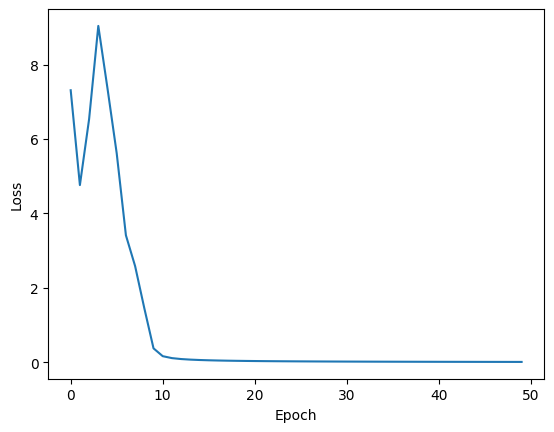

In [19]:
plt.plot(train_history['epoch'], train_history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')